In [2]:
def comp_Zca(lx, a, dt=1, strict=False, dx=1e-3, zcmin=1e-8, mindx=1e-3):
    import math
    dzc={}
    tmax=len(lx)
    for i in range(0,tmax-dt):
        x=lx[i+dt]
        lastx=lx[i]
        d=abs(x-lastx)
        if a<0 and d<mindx:d=mindx
        if a==0: d=1 
        else: d=float(d)**a
        if dx!=None and not strict: 
            x=math.floor(x/dx)*dx
            lastx=math.floor(lastx/dx)*dx
        if lastx<x:
            dzc[lastx]=dzc.get(lastx,0)+d
            dzc[x]=dzc.get(x,0)-d
        else:  
            dzc[x]=dzc.get(x,0)+d
            dzc[lastx]=dzc.get(lastx,0)-d
    keys=list(dzc.keys())
    keys.sort()
    lx=[]
    ly=[]
    z=0
    for x in keys:
        lx.append(x)
        ly.append(float(z)/dt/2)
        z=z+dzc[x]
        if strict:
            lx.append(x)
            y=float(z)/dt/2
            if y<zcmin: y=0.0
            ly.append(y)
    if not strict:
        ly[0]=ly[1] # ly[0] equals 0, but a non-zero value is more convenieint for further analysis
    return lx,ly 

def comp_Zh(lx,dx):
    import math
    zh={}
    for x in lx:    
        x=math.floor(x/dx+0.5)*dx
        zh[x]=zh.get(x,0)+1
    for x in zh:zh[x]=float(zh[x])/dx
    lx=list(zh.keys())
    lx.sort()
    ly=[zh[x] for x in lx]
    return lx,ly
    
def comp_ekn_tp(lrmsd,x0,x1,dx=None,dt=1):
    import math
    def process(lrmsd): # process a TP
        n=len(lrmsd)
        if n<2:return
        for i in range(1,n): # from i-dt to i
            j=i-dt
            if j<0:j=0
            key=lrmsd[j],lrmsd[i]
            ekn[key]=ekn.get(key,0)+1
        for i in range(max(n-dt,1),n-1):
            key=lrmsd[i],lrmsd[-1]
            ekn[key]=ekn.get(key,0)+1
        if dt>n-1:
            key=lrmsd[0],lrmsd[-1]
            ekn[key]=ekn.get(key,0)+dt-n+1
    
    ekn={}
    ok=False
    lx=[]
    if dx!=None: 
        x0=math.floor(x0/dx)*dx
        x1=math.floor(x1/dx)*dx
    for x in lrmsd:
        if dx!=None:x=math.floor(x/dx)*dx
        if x<=x0:
            lx.append(x0)
            if ok:process(lx)
            lx=[x0]
            ok=True
            continue
        if x>=x1:  
            lx.append(x1)
            if ok:process(lx)
            lx=[x1]
            ok=True
            continue
        lx.append(x)
    process(lx)
    for ij in ekn:ekn[ij]=float(ekn[ij])/dt   
    return ekn

def comp_Zca_ekn(ekn,a,dx=None,eps=None,zcmin=1e-8,initial0=False):
    import math
    dzc={}
    for x,y in ekn:
        d=abs(y-x)**a*ekn[(x,y)]
        if dx!=None: 
            x=math.floor(x/dx)*dx
            y=math.floor(y/dx)*dx
        if y<x:
            dzc[y]=dzc.get(y,0)+d
            dzc[x]=dzc.get(x,0)-d
        else:  
            dzc[x]=dzc.get(x,0)+d
            dzc[y]=dzc.get(y,0)-d
    keys=list(dzc.keys())
    keys.sort()
    lx=[]
    ly=[]
    z=0
    for x in keys:
        lx.append(x)
        ly.append(float(z)/2)
        z=z+dzc[x]
        if eps!=None:
            lx.append(x+eps)
            y=float(z)/2
            if y<zcmin: y=0
            ly.append(y)
    if not initial0:ly[0]=ly[1] # ly[0] equals 0, but a non-zero value is convenieint for further analysis
    return lx,ly 
    
def to_committor(lrmsd,dx,x0,x1):
    import math
    lx,lzc1=comp_Zca(lrmsd,a=1,dx=dx)
    x2q={}
    q=0
    for x,zc1 in zip(lx,lzc1):
        if x<=x0 or x>=x1:continue
        x2q[x]=q,1./zc1
        q+=1./zc1
    qm=q
    lq=[]
    for x in lrmsd:
        xi=math.floor(x/dx)*dx
        if xi<=x0:lq.append(0)
        elif xi>=x1:lq.append(1)
        else:
            q,dqdx=x2q[xi]
            lq.append((q+(x-xi)*dqdx)/qm)
    return lq
    


def comp_Z0c1(lx,dx,strict=False):
    import math
    dzc={}
    tmax=len(lx)
    for i in range(tmax):
        x=lx[i]
        lastx=0
        d=abs(x-lastx)
        if dx!=None and not strict: 
            x=math.floor(x/dx)*dx
            lastx=math.floor(lastx/dx)*dx
        if lastx<x:
            dzc[lastx]=dzc.get(lastx,0)+d
            dzc[x]=dzc.get(x,0)-d
        else:  
            dzc[x]=dzc.get(x,0)+d
            dzc[lastx]=dzc.get(lastx,0)-d
    keys=list(dzc.keys())
    keys.sort()
    lx=[]
    ly=[]
    z=0
    for x in keys:
        lx.append(x)
        ly.append(float(z))
        z=z+dzc[x]
    if not strict:ly[0]=ly[1]
    return lx,ly 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
f=open('redtraj-5-0.rmsd')
traj=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()

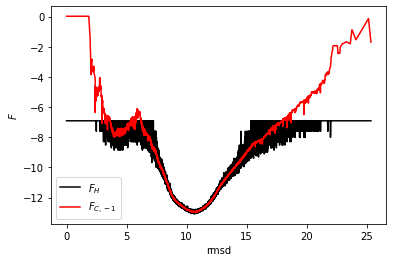

In [5]:
from math import log

dx=0.001
lx,lzh=comp_Zh(lrmsd,dx=dx)
lf=[-log(z) for z in lzh if z>0]

lx2,lzh2=comp_Zca(lrmsd,a=-1,dx=dx)
lf2=[-log(z*2) for z in lzh2 if z>0]

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(lx,lf,'k-',label='$F_H$')
plt.plot(lx2,lf2,'r-',label='$F_{C,-1}$')
plt.legend()
plt.xlabel('rmsd')
_=plt.ylabel('$F$')

In [6]:
from math import sin,cos,pi,log,exp

In [7]:
lq=to_committor(lrmsd,0.0001,4,11)

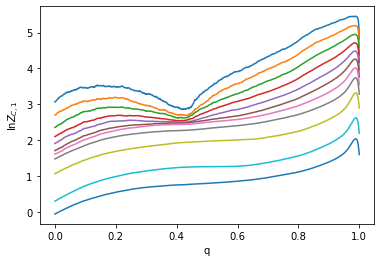

In [8]:
ldt=[2**i for i in range(11)]
dx=0.001
for dt in ldt:
    lx,lzc1=comp_Zca(lq,a=1,dx=dx,dt=dt)
    plt.plot(lx,np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

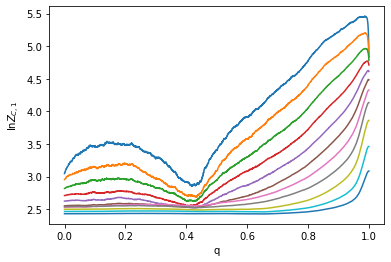

In [9]:
dx=0.0001
for dt in ldt:
    ekn=comp_ekn_tp(lq,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=comp_Zca_ekn(ekn,a=1)
    plt.plot(lx,np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [6]:
import numpy as np
lQ=np.load('redtraj-5-0.rmsd')


lx,lzh=comp_Zca(lQ,a=-1,dx=0.001)
lf=[-log(zh) for zh in lzh]
plt.plot(lx,lf)
plt.ylabel('F/kT')
_=plt.xlabel('Q')

ValueError: Cannot load file containing pickled data when allow_pickle=False